In [1]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device ,torch.cuda.is_available())

cuda True


In [2]:
torch.cuda.is_available()

True

In [3]:
import sys,os, pickle

import torch.nn as nn
from transformers import BertModel, BertTokenizer
from transformers import BertForMaskedLM
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset, random_split
from transformers import AdamW
from tqdm import tqdm  # for our progress bar

from sklearn.metrics import precision_recall_fscore_support , accuracy_score,f1_score
import numpy as np
from transformers import AutoModelForSequenceClassification

import random


EXPERIMENT_NAME="TYPE_WRITER_BERT_final_O_0123"

BATCH_SIZE = 30
MAX_TOKEN_SIZE = 512

MODEL_SAVE_PATH =  '/home/raisul/models/'

In [4]:
data_paths = [
             '/home/raisul/type_data/instructions_and_type_data_100k/',
              '/home/raisul/type_data/O1_mix/instructions_and_type_data_100k',
              '/media/raisul/nahid_personal/optimizations/O2_ghidra/instructions_and_type_data_100k_mix/',
              '/home/raisul/type_data/O3_mix/instructions_and_type_data_100k'
             ]

all_bins_paths = []
for oi,data_path in enumerate(data_paths):
    for fi,pkl_file_name in enumerate(os.listdir(data_path)):
            if fi>200000:
                 break
            user_of_proj = pkl_file_name.split('_____')[0]
            pkl_path = os.path.join(data_path,pkl_file_name)
            all_bins_paths.append( (pkl_path,oi ,user_of_proj) )
            


In [5]:
def fix_types(type_name):
    global TYPE_FIX_MAP
    
    prev_type_name= type_name
    
    if '*' in type_name:
        if type_name.rindex('*')>0:#reduce to single * (rightmost, ignore array before that)
            type_name = type_name[ type_name.rindex('*'): ]
    if 'array_' in type_name:
        if type_name.rindex('array_')>0:
            type_name = type_name[ type_name.rindex('array_'): ]
    if 'unsigned char' in type_name:
        type_name = type_name.replace('unsigned char' , 'char')
        
        
    if type_name not in TYPE_FIX_MAP:
        TYPE_FIX_MAP[prev_type_name] = type_name
    return type_name



In [6]:


TYPE_COUNT ={}
FINAL_TYPE_COUNT = {}
TYPE_PROBABILITY = {}


REJECT = ['union' , 'enumeration' , 'int128' , '_Bool' , 'complex' ,'bool']
TYPE_FIX_MAP = {}
MAX_TYPE_SAMPLE  =20*1000
TYPE_MAPPING = {}


ALL_INPUT_LIST = []
ALL_INPUT_SLICE_INFO  = []
ALL_LABEL_LIST = []
ALL_OPT_LIST = []

TRAIN_SAMPLE_COUNT = 0
VAL_SAMPLE_COUNT   =0


In [7]:
import traceback
#TODO dont load all at a time in memry
def make_dataset():
    global TYPE_FIX_MAP, REJECT ,TYPE_COUNT,TYPE_MAPPING,TRAIN_SAMPLE_COUNT,VAL_SAMPLE_COUNT
    
    dbg_temp = []
    
    #count how many real samples
    for pkl_path, oi, user_proj_name in all_bins_paths:


        with open(pkl_path, 'rb') as file:
            try:
                model_input_list, model_type_list = pickle.load(file)

            except Exception as e:
                pass
            for i in range(len(model_input_list)):

                type_str = fix_types(model_type_list[i])
                
                if type_str not in TYPE_COUNT:
                    TYPE_COUNT[type_str] = 0
                    FINAL_TYPE_COUNT[type_str] = 0
                
                TYPE_COUNT[type_str] +=1

    print(TYPE_COUNT)
    
    #remove the unwanted types
    temp_removed_keys = []
    for rk in REJECT:
        for tk in TYPE_COUNT:
            
            if rk in tk:
                print("DBG 1", rk,tk)
                temp_removed_keys.append(tk)
        for tfm in TYPE_FIX_MAP:
            if tfm in rk:
                print("DBG 2", tfm,rk)
                temp_removed_keys.append(rk)
    print('temp_removed_keys',temp_removed_keys)
    for trk in temp_removed_keys:
        if trk in TYPE_COUNT:
            TYPE_COUNT.pop(trk)
        if trk in FINAL_TYPE_COUNT:
            FINAL_TYPE_COUNT.pop(trk)
        if trk in TYPE_FIX_MAP:
            TYPE_FIX_MAP.pop(trk)
    
    TYPE_COUNT = {k: v for k, v in sorted(TYPE_COUNT.items(), key=lambda item: item[1] , reverse=True)}


    ti = 0
    for key,val in TYPE_COUNT.items():
        TYPE_MAPPING[key]  = ti
        ti+=1

    #make the probability
    for key in TYPE_COUNT.keys():
        print(MAX_TYPE_SAMPLE , TYPE_COUNT[key] ,key)
        TYPE_PROBABILITY[key] = MAX_TYPE_SAMPLE/TYPE_COUNT[key]
    

    print(TYPE_PROBABILITY)
    
    
    ######################################
    #######################################
    

    #fill dataset with that probability
    for pkl_path,oi, user_proj_name in all_bins_paths:
        
        bin_numeric_value = sum(bytearray(user_proj_name,'utf-8') )%10
        
        
        with open(pkl_path, 'rb') as file:
            try:
                model_input_list, model_type_list = pickle.load(file)
            except Exception as e:
#                 print('err: ',e)
                pass
            for i in range(len(model_input_list)):
                
                try:
                    type_str = TYPE_FIX_MAP[model_type_list[i]]
                    type_label = TYPE_MAPPING[type_str]

                    backward_slice , target_slice, forward_slice = model_input_list[i]

                    if random.random()<=TYPE_PROBABILITY[type_str]:
                        
                        if bin_numeric_value>7:
                            
                            
                            ALL_INPUT_LIST.append(backward_slice + target_slice + forward_slice)
                            ALL_INPUT_SLICE_INFO.append([len(backward_slice) , len(target_slice) , len(forward_slice)])
                            ALL_LABEL_LIST.append(type_label)
                            ALL_OPT_LIST.append(oi)
                            VAL_SAMPLE_COUNT = VAL_SAMPLE_COUNT + 1
                        else:
                            
                            ALL_INPUT_LIST.insert( 0,  backward_slice + target_slice + forward_slice)
                            ALL_INPUT_SLICE_INFO.insert( 0 , [len(backward_slice) , len(target_slice) , len(forward_slice)])
                            ALL_LABEL_LIST.insert( 0 , type_label)
                            ALL_OPT_LIST.insert(0,oi)
                            TRAIN_SAMPLE_COUNT=TRAIN_SAMPLE_COUNT+1


                        FINAL_TYPE_COUNT[type_str]+=1
                except Exception as e:
                    pass
#                       print('err: _',e)
#                       print(traceback.print_exc())

make_dataset()
print(VAL_SAMPLE_COUNT , TRAIN_SAMPLE_COUNT)


{'int': 7780112, '*char': 621750, 'structure': 1236172, 'long int': 110663, '*int': 818128, 'array_int': 1598244, 'char': 253619, 'array_char': 442244, '*structure': 1165780, 'short int': 23431, 'array_structure': 15820, 'float': 273813, 'double': 171007, 'unsigned int': 157359, '*double': 18913, 'long unsigned int': 32338, '*float': 14241, 'enumeration': 10864, 'union': 4170, 'array_float': 65766, 'long long int': 62716, 'array_double': 47898, 'array_short int': 5118, '_Bool': 1003, 'short unsigned int': 14611, '*union': 8636, '*unsigned int': 10855, 'long long unsigned int': 29475, '*long int': 12763, '*enumeration': 977, 'signed char': 134224, '*long long unsigned int': 931, 'array_unsigned int': 38572, 'array_long long int': 10356, '*long unsigned int': 3910, 'array_long long unsigned int': 944, 'array_long int': 12747, 'array_long unsigned int': 866, '*short int': 4416, '*_Bool': 145, '*long long int': 5388, '*short unsigned int': 2232, 'array_short unsigned int': 833, '*signed ch

In [4]:
data_temp_path = 'data/typedata'+EXPERIMENT_NAME+'.ignore.pkl'
# with open(data_temp_path, 'wb') as f:
#     pickle.dump([ALL_OPT_LIST,VAL_SAMPLE_COUNT , TRAIN_SAMPLE_COUNT,TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,   FINAL_TYPE_COUNT ], f)
    
    
with open(data_temp_path, 'rb') as file:
    ALL_OPT_LIST,VAL_SAMPLE_COUNT , TRAIN_SAMPLE_COUNT,TYPE_COUNT , TYPE_MAPPING ,ALL_INPUT_LIST, ALL_INPUT_SLICE_INFO ,ALL_LABEL_LIST,     FINAL_TYPE_COUNT  = pickle.load(file)    

In [5]:

print(len(ALL_INPUT_LIST), FINAL_TYPE_COUNT)

620602 {'int': 20066, '*char': 16735, 'structure': 19804, 'long int': 19913, '*int': 18824, 'array_int': 19395, 'char': 18415, 'array_char': 19099, '*structure': 18383, 'short int': 19930, 'array_structure': 13174, 'float': 19809, 'double': 20057, 'unsigned int': 20016, '*double': 18793, 'long unsigned int': 20058, '*float': 13052, 'array_float': 19481, 'long long int': 20190, 'array_double': 19633, 'array_short int': 5046, 'short unsigned int': 14611, '*unsigned int': 10491, 'long long unsigned int': 20046, '*long int': 11943, 'signed char': 19888, '*long long unsigned int': 877, 'array_unsigned int': 19888, 'array_long long int': 10039, '*long unsigned int': 3797, 'array_long long unsigned int': 740, 'array_long int': 12517, 'array_long unsigned int': 852, '*short int': 4145, '*long long int': 4970, '*short unsigned int': 1763, 'array_short unsigned int': 647, '*signed char': 19908, 'array_signed char': 19898, '*long double': 4, 'long double': 122, 'unsigned long int': 20239, 'unsign

In [6]:
tokenizer  = BertTokenizer.from_pretrained("./multytask-tokenizer_optim_3_d4")

#https://github.com/huggingface/tokenizers/issues/247

mask_token_id, look_token_id, eoi_token_id = tokenizer.encode('[MASK] [LOOK] [EOI]')[1:-1]

print(mask_token_id, look_token_id, eoi_token_id)

4 6 5


In [7]:

VOCAB_SIZE = tokenizer.vocab_size

print('VOCAB SIZE : ', (tokenizer.vocab_size))

VOCAB SIZE :  3000


In [8]:
# Create model instance
#TODO*** USE PRETRAINED
# PATH, local_files_only=True #/home/raisul/models/pretrain_100k #bert-base-uncased
model = AutoModelForSequenceClassification.from_pretrained("/home/raisul/models/pretrain_100k_O2", num_labels=len(TYPE_MAPPING.items()))
# model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH  + EXPERIMENT_NAME, num_labels=len(TYPE_MAPPING.items()))
model.to(device)


print(model.config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /home/raisul/models/pretrain_100k_O2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertConfig {
  "_name_or_path": "/home/raisul/models/pretrain_100k_O2",
  "architectures": [
    "BertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18",
    "19": "LABEL_19",
    "20": "LABEL_20",
    "21": "LABEL_21",
    "22": "LABEL_22",
    "23": "LABEL_23",
    "24": "LABEL_24",
    "25": "LABEL_25",
    "26": "LABEL_26",
    "27": "LABEL_27",
    "28": "LABEL_28",
    "29": "LABEL_29",
    "30": "LABEL_30",
    "31": "LABEL_31

In [9]:

# Tokenize input text
# inputs = tokenizer(input_text, padding=True, truncation=True, return_tensors='pt')
# inputs = tokenizer(ALL_INPUT_LIST, max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')
# print(inputs.keys())

# labels = ALL_LABEL_LIST.to(device)

In [10]:
# print(inputs.keys())
# print(inputs.token_type_ids)
# inputs.token_type_ids[0][0] =1
# print(inputs.token_type_ids)
# #TODO set token type ids

In [11]:
# class BinaryDataset(torch.utils.data.Dataset):
#     def __init__(self, encodings):
#         self.encodings = encodings
#     def __getitem__(self, idx):
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
#     def __len__(self):
#         return len(self.encodings.input_ids)

In [12]:
class BinaryDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        
    def __getitem__(self, index):
        text = self.texts[index]
        label = self.labels[index]
        
        # Tokenize the text
        tokenized_text = (self.tokenizer(text , max_length= MAX_TOKEN_SIZE,padding='max_length', truncation=True , return_tensors='pt')).to(device)
        
        # Convert tokens to input IDs
#         input_ids = self.tokenizer.convert_tokens_to_ids(tokenized_text)
        
        # Create input tensors
#         input_ids = tokenized_text['input_ids']  #torch.tensor(input_ids)
        label = torch.tensor([label]).to(device)
        
        return tokenized_text, label
        
#         return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.texts)

In [13]:

dataset = BinaryDataset(ALL_INPUT_LIST, ALL_LABEL_LIST,tokenizer)
# train_size = int(0.8 * len(dataset))
# validation_size = len(dataset) - train_size



# Created using indices from 0 to train_size.
train_dataset = torch.utils.data.Subset(dataset, range(TRAIN_SAMPLE_COUNT))

# Created using indices from train_size to train_size + test_size.
validation_dataset = torch.utils.data.Subset(dataset, range(TRAIN_SAMPLE_COUNT, TRAIN_SAMPLE_COUNT + VAL_SAMPLE_COUNT))


# train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [train_size, validation_size])



train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE ,shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [14]:
TRAIN_SAMPLE_COUNT,  VAL_SAMPLE_COUNT
len(validation_dataset),VAL_SAMPLE_COUNT, TRAIN_SAMPLE_COUNT+VAL_SAMPLE_COUNT- len(dataset)

(118203, 118203, 0)

In [15]:
dataset_path = 'data/typedata_dataset'+EXPERIMENT_NAME+'.ignore.pkl'
with open(dataset_path, 'wb') as f:
    pickle.dump([train_dataset, validation_dataset], f)
    
    
with open(dataset_path, 'rb') as file:
    train_dataset, validation_dataset  = pickle.load(file)    
    
    
# train_loader      = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE ,shuffle=True) 
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [16]:
len(validation_loader), len(train_loader)


(3941, 16747)

In [17]:
# global_task2_metrices, global_task1_metrices ,v_global_task1_metrices, v_global_task2_metrices

from numpy import *
import math
import matplotlib.pyplot as plt


def plot_graph(task1_metrices,   v_task1_metrices, label = "TypeGraph" ):
    
    plt.ioff()

    font_size = 10
    x_labels = [ i for i in range(len(task1_metrices)) ]
    
    task1_f1 = [ i['f1'] for i in task1_metrices ]

    
    v_task1_f1 = [ i['f1'] for i in v_task1_metrices ]

    

    plt.ylabel(' F1 ',fontsize=font_size)
    plt.plot(x_labels, task1_f1 , 'r') 

    print(x_labels, v_task1_f1 )
    plt.plot(x_labels, v_task1_f1 , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val' ], loc='upper left')
    
    plt.savefig('./output/'+label+'_f1.pdf')
    plt.close()
    plt.show()
    
    ################################
    ################# LOSS #########
    ################################
    
    task1_loss = [ i['loss'] for i in task1_metrices ]

    
    v_task1_loss = [ i['loss'] for i in v_task1_metrices ]
    

    plt.ylabel(' LOSS ',fontsize=font_size)
    plt.plot(x_labels, task1_loss , 'r') 
    
    plt.plot(x_labels, v_task1_loss , 'r' , linestyle = '--') 

    
    plt.xlabel("Epoch", fontsize=font_size)
    plt.title(label,fontsize=font_size)
    plt.legend([' Type Train',  'Type Val'], loc='upper left')
    
    plt.savefig('./output/'+label+'_loss.pdf')
    plt.close()
    plt.show()
    
    

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, label='confusion_matrix'):

    class_labels = list(TYPE_MAPPING.keys())  
    class_labels = [c for c in class_labels]

    cm = confusion_matrix(true_labels, predicted_labels ) 
    
    conf_per_class = cm.diagonal()/cm.sum(axis=1)
    average_acc = sum([i for i in conf_per_class  if not math.isnan(i)] )/len(conf_per_class)
    
    print('CONFUSION PER CLASS' , conf_per_class,average_acc)
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    res = sns.heatmap(cm,
            annot=True , cmap="Blues" , fmt='g' , xticklabels=class_labels,linewidths = .01,
                      yticklabels=class_labels,linecolor="Gray")
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
    
    plt.ylabel('Actual',fontsize=13)
    plt.xlabel('Prediction',fontsize=13)
    plt.title('Confusion Matrix',fontsize=17)
    plt.savefig('./output/'+label+'_conf.pdf',dpi=200)
    plt.show()
    plt.close()
    
    f1_score_per_class = f1_score(true_labels, predicted_labels, average=None)
    print(f1_score_per_class,class_labels)
    f1_scores_with_labels = {label:score for label,score in zip(class_labels, f1_score_per_class)}
    print(f1_scores_with_labels)
# plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)

In [19]:
  #--optimizer adam --adam-betas '(0.9,0.98)' --adam-eps 1e-6 --clip-norm 0.0 \
 # --lr-scheduler polynomial_decay --lr $PEAK_LR --warmup-updates $WARMUP_UPDATES --total-num-update $TOTAL_UPDATES \
  #--dropout 0.1 --attention-dropout 0.1 --weight-decay 0.01 \

#     ( params: typing.Iterable[torch.nn.parameter.Parameter]lr: float = 0.001betas: typing.Tuple[float, 
# float] = (0.9, 0.999)eps: float = 1e-06weight_decay: float = 0.0correct_bias: bool = Trueno_deprecation_warning: bool = False )
    
# initialize optimizer
optim = AdamW( model.parameters() , lr=1e-5, eps = 1e-6, betas=(0.9,0.98), weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
def training_loop(model ,data_loop, is_training = False):
    
    prediction_s, ground_truth_s = [], []
    losses = []

    for N,batch in enumerate(data_loop):

        # Forward pass
        if is_training == True:
            optim.zero_grad()
        
        batch_input, batch_labels = batch
        if len(batch_labels)<BATCH_SIZE:
            continue
        batch_input_ids= batch_input['input_ids']
        batch_attention_mask=batch_input['attention_mask']
        batch_token_type_ids =batch_input['token_type_ids']

        outputs = model(input_ids=batch_input_ids.squeeze(),
                        attention_mask=batch_attention_mask.squeeze(),
                        token_type_ids=batch_token_type_ids.squeeze(),
                        labels=batch_labels )
        
#

        loss = outputs.loss
        losses.append(loss.item())
        
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1)
        


        prediction_s.extend(predictions.detach().cpu().numpy().flatten())
        ground_truth_s.extend(batch_labels.detach().cpu().numpy().flatten())


        if is_training == True:
            loss.backward()
            optim.step()


        # print relevant info to progress bar
        data_loop.set_description(f'Epoch {ecpoch}')
        data_loop.set_postfix(loss=loss.item())

    ###### Training Scores
    accuracy = accuracy_score(ground_truth_s, prediction_s)    
    precision, recall, f1, _ = precision_recall_fscore_support(ground_truth_s,prediction_s,average='weighted')
    metrices = {'accuracy':accuracy ,
                      'precision':precision, 
                      'recall':recall, 
                      'f1':f1,
                      'loss': (sum(losses) / len(losses))}
    


    return metrices , prediction_s, ground_truth_s
    

In [ ]:
EPOCHS = 30


global_metrices = []
v_global_metrices = []

Epoch 1: 100%|███████████████████████████████████████████████████| 16747/16747 [2:16:02<00:00,  2.05it/s, loss=0.604]
/home/raisul/anaconda3/envs/pytorch/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training metrices:  {'accuracy': 0.814992635057128, 'precision': 0.8162925679141896, 'recall': 0.814992635057128, 'f1': 0.8141120938785095, 'loss': 0.6055069579311836}


Epoch 1: 100%|████████████████████████████████████████████████████████| 3941/3941 [12:18<00:00,  5.33it/s, loss=1.51]


CONFUSION PER CLASS [0.84819277 0.79973082 0.68227666 0.57717414 0.80778648 0.26176675
 0.76094003 0.45411272 0.97469689 0.79052305 0.7557564  0.92087212
 0.66159052 0.89697681 0.00465116 0.51735913 0.4334119  0.83151804
 0.69030521 0.83740192 0.35913043 0.58007234 0.29277108 0.83945205
 0.79214123 0.57198953 0.90531401 0.86282051 0.34609495 0.32252142
 0.54434994 0.6015444  0.56148148 0.2501067  0.21428571 0.50479616
 0.59574468 0.17374517 0.22423146 0.12222222 0.71139241 0.45583039
 0.         0.55       0.56097561 0.03763441 0.3374613  0.57763975
 0.        ] 0.5388325083761449


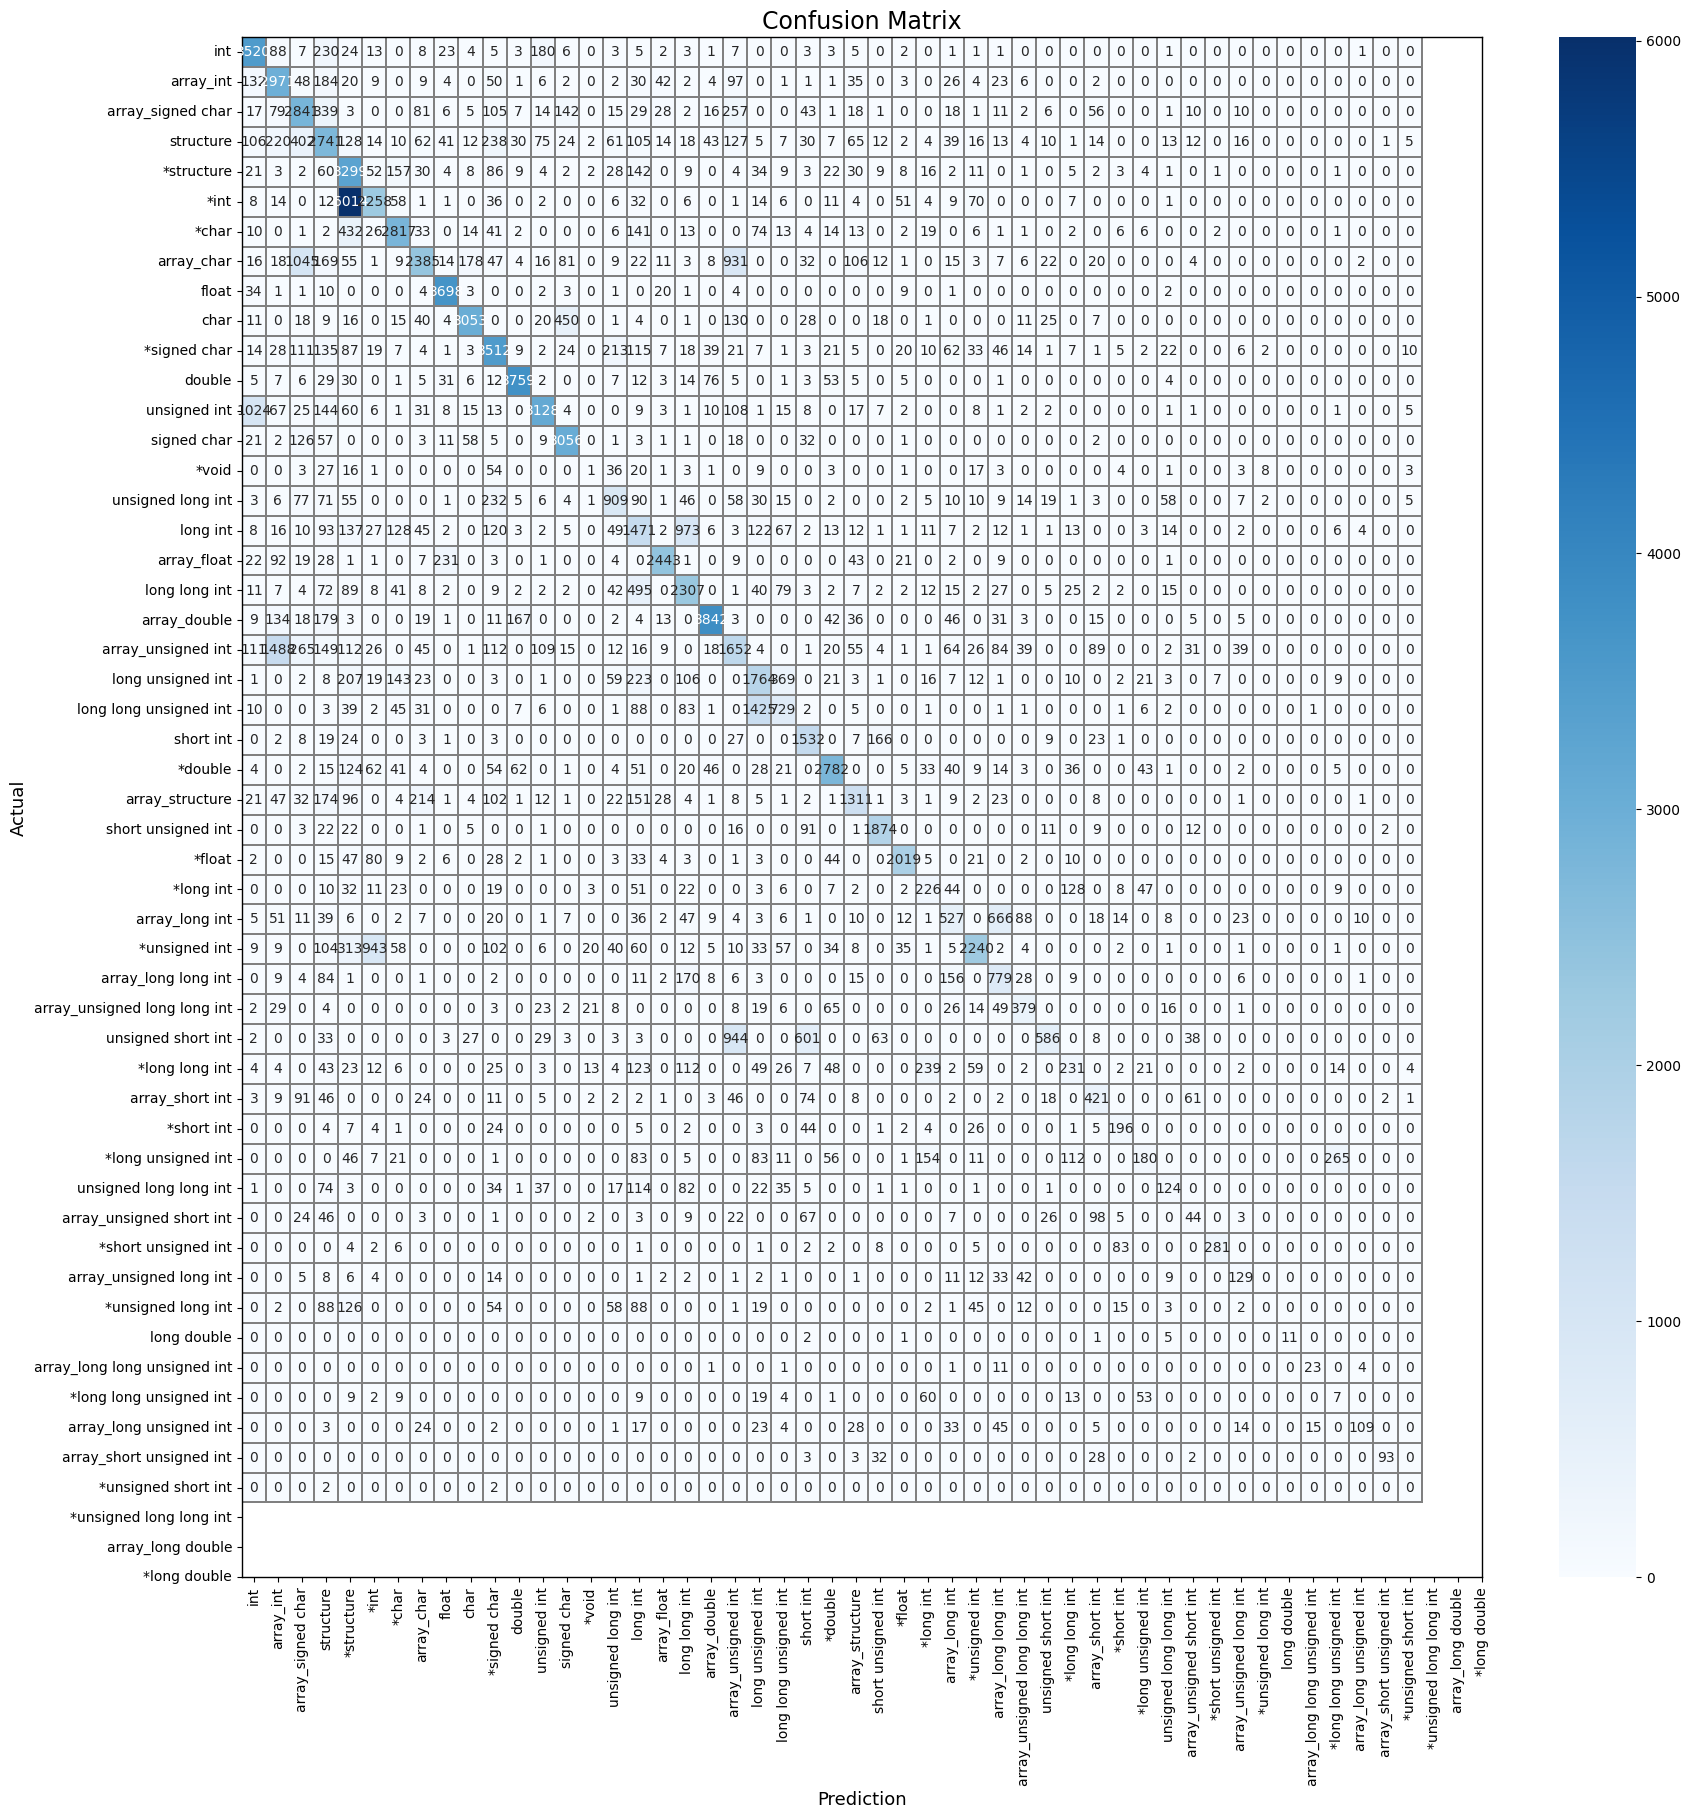

[0.75560803 0.651678   0.60608    0.53053324 0.41759494 0.36910503
 0.77030353 0.56724938 0.93762677 0.84127859 0.71367608 0.92177538
 0.7418475  0.84408231 0.0070922  0.53691672 0.40345584 0.87609826
 0.61991133 0.88058675 0.3618839  0.51219512 0.36623964 0.68792097
 0.81968179 0.63180723 0.87508756 0.88649835 0.3056119  0.37349398
 0.6605721  0.486875   0.56567164 0.37990276 0.27353464 0.50388989
 0.57817109 0.25316456 0.28770302 0.15172414 0.81924198 0.46486486
 0.         0.70967742 0.575      0.02772277 0.47912088 0.71814672
 0.        ] ['int', 'array_int', 'array_signed char', 'structure', '*structure', '*int', '*char', 'array_char', 'float', 'char', '*signed char', 'double', 'unsigned int', 'signed char', '*void', 'unsigned long int', 'long int', 'array_float', 'long long int', 'array_double', 'array_unsigned int', 'long unsigned int', 'long long unsigned int', 'short int', '*double', 'array_structure', 'short unsigned int', '*float', '*long int', 'array_long int', '*unsigned i

Epoch 2:  52%|██████████████████████████▊                         | 8637/16747 [1:01:37<59:53,  2.26it/s, loss=0.352]

In [ ]:



for ecpoch in range(EPOCHS):
#     if ecpoch==0:
#         continue
    train_loop = tqdm(train_loader, leave=True)
    model.train()
    metrices,prediction_s, ground_truth_s  = training_loop(model ,train_loop, is_training = True)
    print('Training metrices: ',metrices)
    global_metrices.append(metrices)
    
    with torch.no_grad():
        model.eval()
        validation_loop = tqdm(validation_loader, leave=True)
        v_metrices, v_prediction_s, v_ground_truth_s  = training_loop(model ,validation_loop, is_training = False)
        plot_confusion_matrix(v_ground_truth_s , v_prediction_s ,label=EXPERIMENT_NAME)
        print('v_metrices: ',v_metrices)
        v_global_metrices.append(v_metrices)
    plot_graph(global_metrices,v_global_metrices , label = EXPERIMENT_NAME)
    print('SAVING MODEL @ ',MODEL_SAVE_PATH +EXPERIMENT_NAME)
#     model.save_pretrained(MODEL_SAVE_PATH +EXPERIMENT_NAME)


In [23]:
model.save_pretrained( MODEL_SAVE_PATH  + EXPERIMENT_NAME )

In [ ]:
print('Alhamdulillah')